## Task - SMS Classifier: Develop a text classification model to classify SMS as either spam or non-spam using data science techniques in Python.





## Importing Necessary Libraries

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings as warn
warn.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,recall_score,roc_auc_score,roc_curve,auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Cleaning


In [2]:
df = pd.read_csv('/content/spam.csv',encoding = "ISO-8859-1")

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.rename(columns = {'v1':'type','v2':'sms'},inplace=True)

In [7]:
df.head()

,type,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.shape

(5572, 2)

In [9]:
df.duplicated().sum()

403

In [10]:
df = df.drop_duplicates(keep='first')

In [11]:
df.isna().sum()

type    0
sms     0
dtype: int64

In [12]:
df.shape

(5169, 2)

In [13]:
df['type'].unique()

array(['ham', 'spam'], dtype=object)

In [14]:
df['type'].value_counts()

type
ham     4516
spam     653
Name: count, dtype: int64

In [15]:
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])

In [16]:
df.head()

,type,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df['type'].value_counts()

type
0    4516
1     653
Name: count, dtype: int64

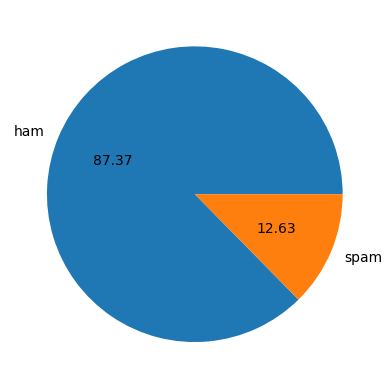

In [18]:
plt.pie(df['type'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

## Exploratory Data Analysis

In [21]:
df['num_characters'] = df['sms'].apply(len)

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
df['num_words'] = df['sms'].apply(lambda x: len(nltk.word_tokenize(x)))

In [25]:
df['num_sentences'] = df['sms'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [26]:
df.head()

,type,sms,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [28]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


### Ham Description

In [32]:
df[df['type']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


### Spam Description

In [33]:
df[df['type']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

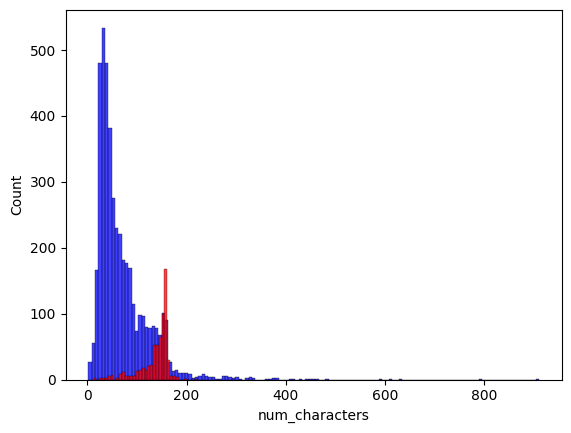

In [35]:
sns.histplot(df[df['type']==0]['num_characters'],color='blue')
sns.histplot(df[df['type']==1]['num_characters'],color='red')

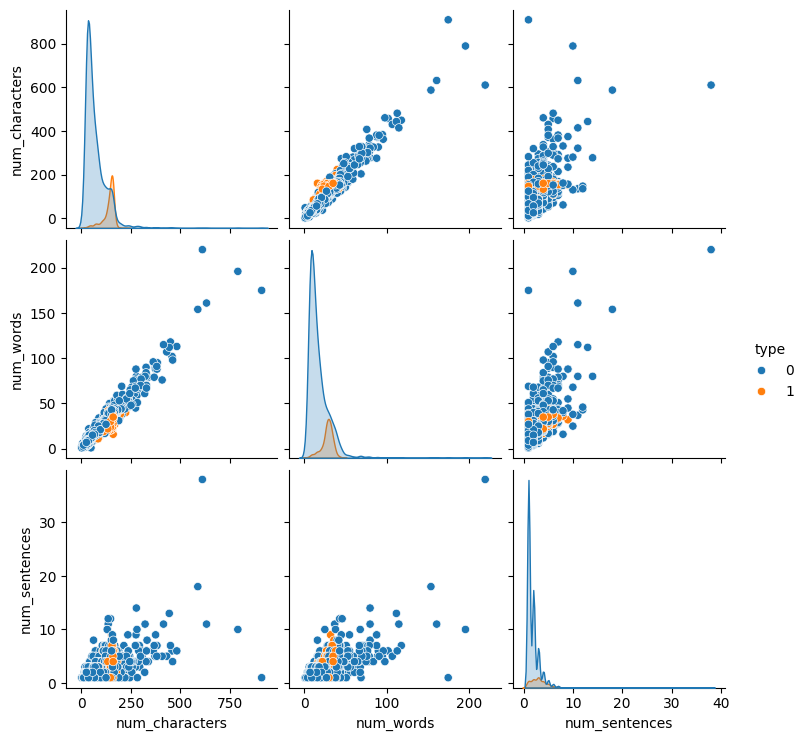

In [37]:
sns.pairplot(df,hue='type')

<Axes: >

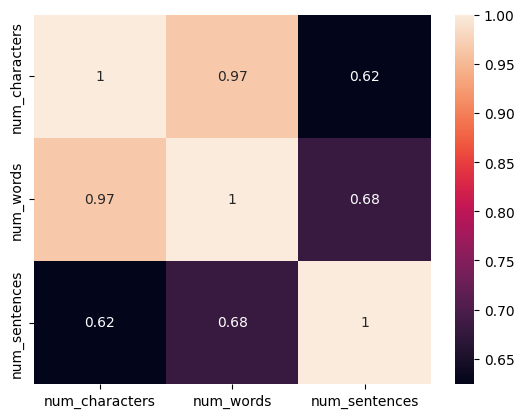

In [41]:
sns.heatmap(df[['num_characters','num_words','num_sentences']].corr(),annot=True)

## Data Preprocessing

In [56]:
ps = PorterStemmer()

In [57]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [60]:
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)
  li = list()
  for word in text:
    if word.isalnum():
      li.append(word)
  text = li.copy()
  li.clear()
  for word in text:
    if word not in stop_words and word not in punctuation:
      li.append(word)
  text = li.copy()
  li.clear()
  for word in text:
    li.append(ps.stem(word))
  text = " ".join(li)
  return text

In [61]:
df['transformed_sms'] = df['sms'].apply(transform_text)

In [62]:
df.head()

,type,sms,num_characters,num_words,num_sentences,transformed_sms
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [75]:
df

,type,sms,num_characters,num_words,num_sentences,transformed_sms
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [93]:
spam_wc = WordCloud(width=100,height=500,background_color='white').generate(df[df['type']==1]['sms'].str.cat(sep=" "))

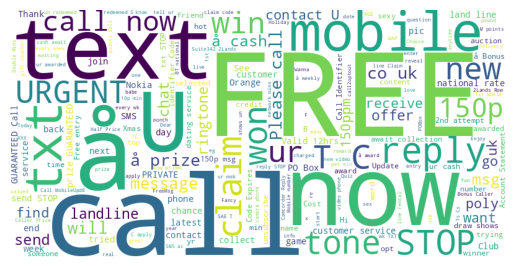

In [92]:
plt.imshow(spam_wc)
plt.axis('off')
plt.show()

In [94]:
ham_wc = WordCloud(width=1000,height=500,background_color='white').generate(df[df['type']==0]['sms'].str.cat(sep=" "))

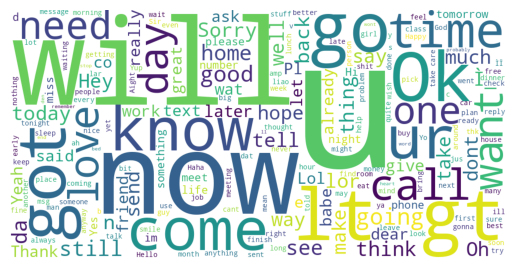

In [95]:
plt.imshow(ham_wc)
plt.axis('off')
plt.show()

In [97]:
spam_corpus = list()
for sms in df[df['type']==1]['sms'].tolist():
  for word in sms.split(" "):
    spam_corpus.append(word)

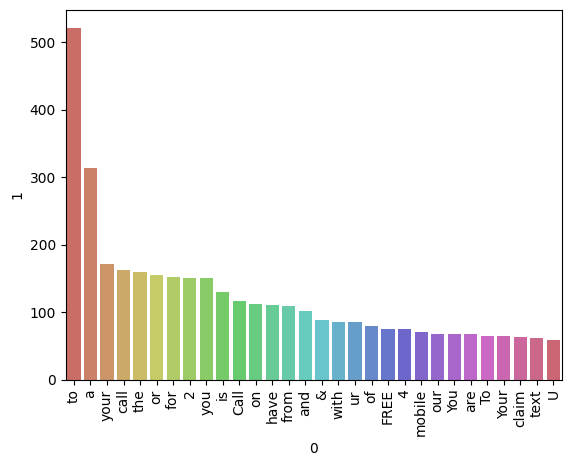

In [110]:
colors = sns.color_palette("hls", 30)
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0],y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1],palette=colors)
plt.xticks(rotation='vertical')
plt.show()

In [114]:
ham_corpus = list()
for sms in df[df['type']==0]['sms'].tolist():
  for word in sms.split(" "):
    ham_corpus.append(word)

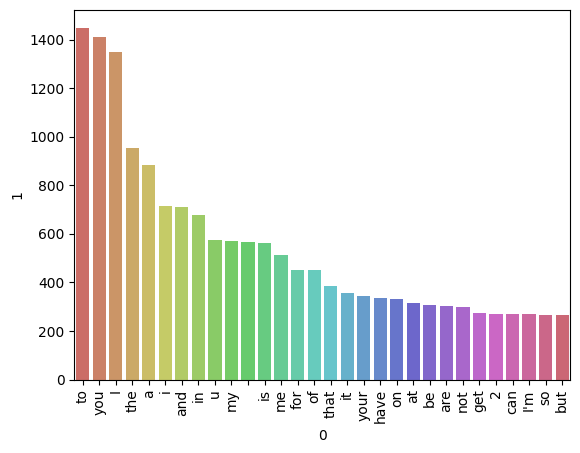

In [115]:
colors = sns.color_palette("hls", 30)
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0],y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1],palette=colors)
plt.xticks(rotation='vertical')
plt.show()

## Model Building

In [118]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [152]:
df['transformed_sms']

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: transformed_sms, Length: 5169, dtype: object

In [120]:
x = tfidf.fit_transform(df['transformed_sms']).toarray()

In [121]:
y = df['type'].values

In [123]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

### Modelling With GaussianNB Classifier

In [163]:
model = GaussianNB()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [164]:
accuracy_score(y_test,y_pred)

1.0

In [165]:
precision_score(y_test,y_pred)

1.0

In [166]:
recall_score(y_test,y_pred)

1.0

In [168]:
roc_auc_score(y_test,y_pred)

1.0

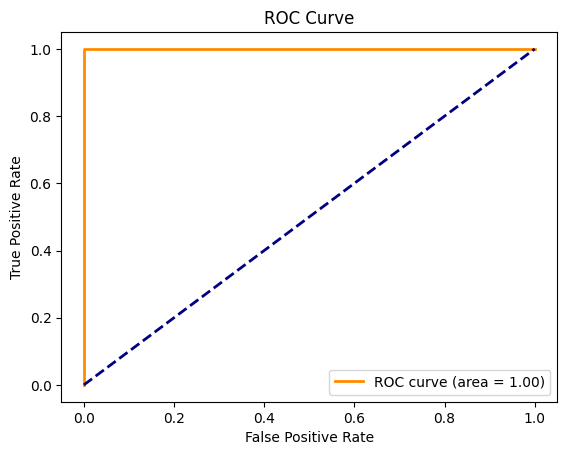

In [169]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

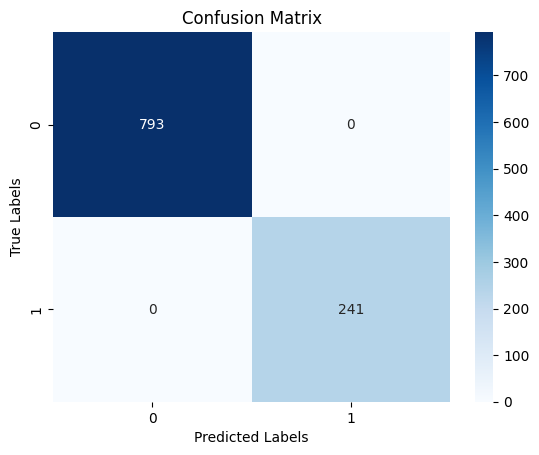

In [170]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Modelling With MultinomialNB Classifier


In [179]:
model = MultinomialNB()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [180]:
accuracy_score(y_test,y_pred)

0.8684719535783365

In [181]:
precision_score(y_test,y_pred)

0.9411764705882353

In [182]:
recall_score(y_test,y_pred)

0.46473029045643155

In [183]:
roc_auc_score(y_test,y_pred)

0.7279515260604983

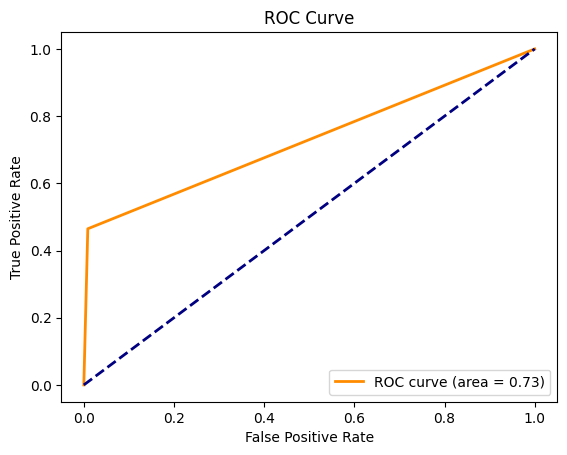

In [187]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

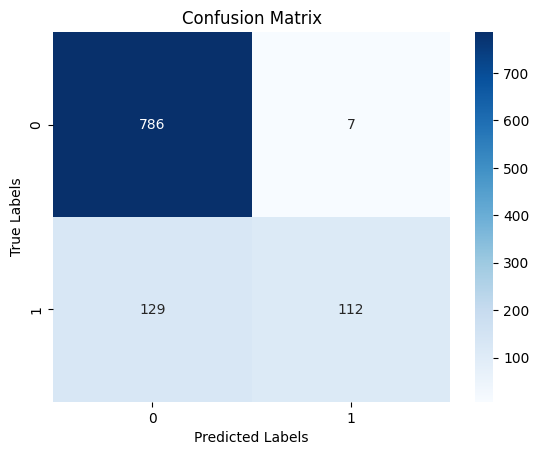

In [188]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Modelling With BernoulliNB Classifier


In [189]:
model = BernoulliNB()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [190]:
accuracy_score(y_test,y_pred)

0.8646034816247582

In [191]:
precision_score(y_test,y_pred)

0.8976377952755905

In [192]:
recall_score(y_test,y_pred)

0.4730290456431535

In [193]:
roc_auc_score(y_test,y_pred)

0.7283178015101014

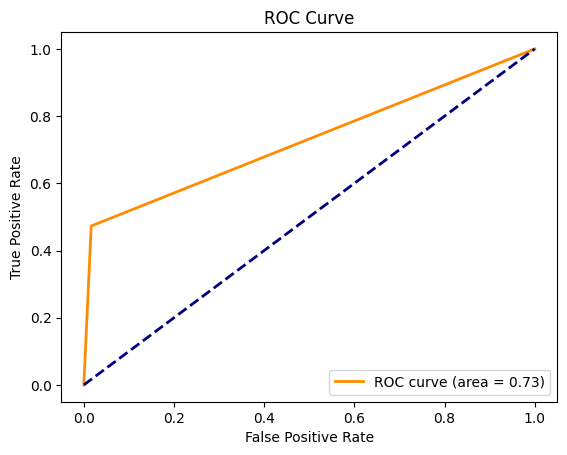

In [194]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

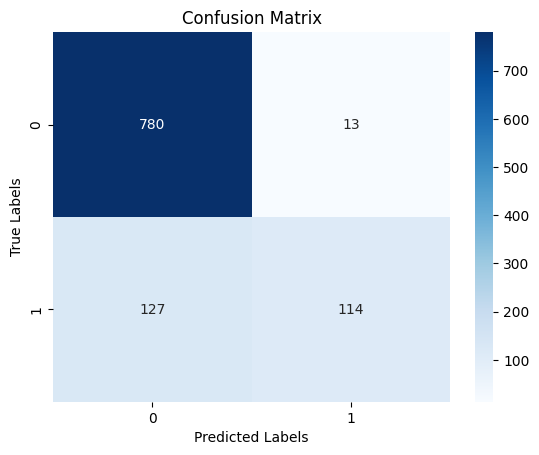

In [195]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Modelling With RandomForest Classifier

In [171]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [172]:
accuracy_score(y_test,y_pred)

0.8655705996131529

In [173]:
precision_score(y_test,y_pred)

0.9396551724137931

In [174]:
recall_score(y_test,y_pred)

0.45228215767634855

In [176]:
roc_auc_score(y_test,y_pred)

0.7217274596704567

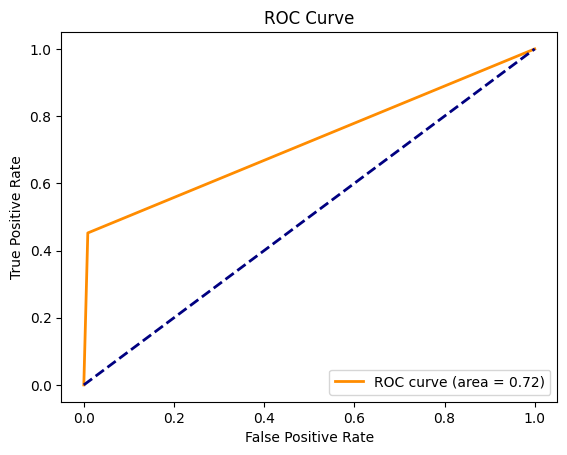

In [177]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

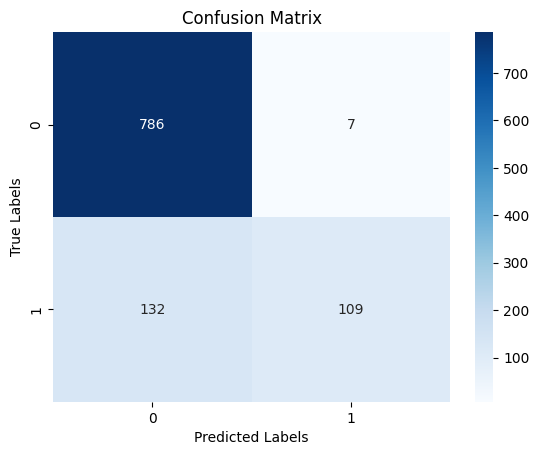

In [178]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()